In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from importlib import reload

In [2]:
titlefontsize = 18

## Files and directories

In [3]:
sstfile = "/data/SST/CapeGhir/V20181722018263.L3m_SNSU_SNPP_NSST_sst_4km.nc"
sstfile2 = "/data/SST/CapeGhir/T20001732018263.L3m_SCSU_NSST_sst_4km.nc"
datafileu = "/data/Wind/SCOW/wind_stress_zonal_monthly_maps.nc"
datafilev = "/data/Wind/SCOW/wind_stress_meridional_monthly_maps.nc"

## Read data
### SST 

In [4]:
SST_clim = filament.SST()
SST_clim.read_from_oceancolorL3(sstfile2)
    
SST_summer2018 = filament.SST()
SST_summer2018.read_from_oceancolorL3(sstfile)

### Wind stress

In [5]:
Windstress = filament.Wind()
Windstress.read_from_scow(datafileu, datafilev)

## Figure
### Prepare projections

In [6]:
m1 = Basemap(projection='ortho',lon_0=-20., lat_0=0, resolution='c')
m2 = Basemap(projection='ortho',lon_0=-120.,lat_0=0, resolution='c')
m3 = Basemap(projection='kav7',lon_0=0,resolution='c')

In [48]:
llon, llat = np.meshgrid(SST_summer2018.lon, SST_summer2018.lat)
lonp1, latp1 = m1(llon, llat)
lonp1[lonp1==lonp1.max()] = np.nan
latp1[latp1==latp1.max()] = np.nan

llon, llat = np.meshgrid(SST_clim.lon, SST_clim.lat)
lonp2, latp2 = m2(llon, llat)
lonp2[lonp2==lonp2.max()] = np.nan
latp2[latp2==latp2.max()] = np.nan

llon, llat = np.meshgrid(SST_clim.lon, SST_clim.lat)
lonp3, latp3 = m3(llon, llat)
lonp3[lonp3==lonp3.max()] = np.nan
latp3[latp3==latp3.max()] = np.nan

### Define EBUS region

In [49]:
ebuscoordinates = [(-30., -5., 15., 35.),
                   (-138., -115., 30., 45.),
                   (-85., -70., -35., -15.),
                   (6., 20., -35., -15.)
                  ]

In [57]:
NN = 10
Nw = 10
fig = plt.figure(figsize=(14, 10))

ax = plt.subplot(1,2,1)
m1.pcolormesh(lonp1[::NN], latp1[::NN], SST_clim.field[::NN], cmap=plt.cm.RdYlBu_r,
             zorder=3, vmin=3., vmax=30.)
m1.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)
plt.title("20-year mean SST", fontsize=titlefontsize)

# m.fillcontinents(color='grey')
#plt.colorbar(extend="both", shrink=.7)

# Add wind
i = 0
for coords in ebuscoordinates:
    Wind_ebus = filament.Wind()
    Wind_ebus.read_from_scow(datafileu, datafilev, domain=coords)
    llon, llat = np.meshgrid(Wind_ebus.lon, Wind_ebus.lat)
    lonw, latw = m1(llon, llat)
    
    """
    if (i == 0) | (i == 3):
        lonc = np.mean(lon)
        latc = np.mean(lat)
        lonc2, latc2 = m1(lonc, latc)
        umean = np.mean(ustress[:,:,6:8])
        vmean = np.mean(vstress[:,:,6:8])
        quiv = m1.quiver(lonc2, latc2, umean, vmean, scale=.35, width=.02,  
                  alpha=.5, zorder=5, headwidth=3, headlength=4.5,
                  edgecolor="k", facecolors=".75", linewidth=1)
        
    #qk = plt.quiverkey(quiv, 1.1, 0.85, 0.075, "Mean wind in upwelling zone\n ", labelpos='N',
    #                   fontproperties={"size":14, "family": "times new roman"})
    
    """
    m1.quiver(lonw[::Nw,::Nw], latw[::Nw,::Nw], 
             np.nanmean(Wind_ebus.u[:,:,:], axis=2)[::Nw,::Nw], 
             np.nanmean(Wind_ebus.v[:,:,:], axis=2)[::Nw,::Nw], scale=3, width=.001, zorder=4)
    
    i += 1
    
ax = plt.subplot(1,2,2)
m2.ax = ax
pcm = m2.pcolormesh(lonp2[::NN], latp2[::NN], SST_clim.field[::NN], cmap=plt.cm.RdYlBu_r,
             zorder=3, vmin=3., vmax=30.)
# m.fillcontinents(color='grey')
m2.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)


# Add wind
i = 0
for coords in ebuscoordinates:
    Wind_ebus = filament.Wind()
    Wind_ebus.read_from_scow(datafileu, datafilev, domain=coords)
    llon, llat = np.meshgrid(Wind_ebus.lon, Wind_ebus.lat)
    lonw, latw = m2(llon, llat)
    
    """
    if (i == 1) | (i == 2):
        lonc = np.mean(lon)
        latc = np.mean(lat)
        lonc2, latc2 = m2(lonc, latc)
        umean = np.mean(ustress[:,:,6:8])
        vmean = np.mean(vstress[:,:,6:8])
        #m2.quiver(lonc2, latc2, umean, vmean, scale=.35, width=.02,  
        #          alpha=.5, zorder=5, headwidth=3, headlength=4.5,
        #          edgecolor="k", facecolors=".75", linewidth=1)
    """
    m2.quiver(lonw[::Nw,::Nw], latw[::Nw,::Nw], 
             np.nanmean(Wind_ebus.u[:,:,:], axis=2)[::Nw,::Nw], 
             np.nanmean(Wind_ebus.v[:,:,:], axis=2)[::Nw,::Nw], scale=3, width=.001, zorder=4, color=".3")
    
    i += 1
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.3, 0.02, 0.4])
cb = plt.colorbar(pcm, cax=cbar_ax, extend="both")
cb.set_label("$^{\circ}$C", rotation=0, ha="left")
plt.savefig(os.path.join(figdir, "SST_wind_summer_2018_07_006"), dpi=300, bbox_inches="tight")
# plt.show()
plt.close()

## Single map with global projection

In [22]:
Wind_ebus = filament.Wind()
Wind_ebus.read_from_scow(datafileu, datafilev, domain=coords)
Wind_ebus.u.shape

(80, 100, 12)

In [56]:
NN = 10
Nw = 10
fig = plt.figure(figsize=(12, 10))

pcm = m3.pcolormesh(lonp3[::NN], latp3[::NN], sst2[::NN], cmap=plt.cm.RdYlBu_r,
             zorder=3, vmin=3., vmax=30.)
# m3.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)

i = 0
for coords in ebuscoordinates:
    """
    lon, lat, ustress = get_wind_stress(datafileu, coords)
    lon, lat, vstress = get_wind_stress(datafilev, coords)
    llon, llat = np.meshgrid(lon, lat)
    lonp, latp = m3(llon, llat)
    
   
    lonc = np.mean(lon)
    latc = np.mean(lat)
    lonc2, latc2 = m3(lonc, latc)
    umean = np.mean(ustress[:,:,6:8])
    vmean = np.mean(vstress[:,:,6:8])
    """
    
    """

    quiv = m3.quiver(lonc2, latc2, umean, vmean, scale=.6, width=.012,  
              alpha=.5, zorder=5, headwidth=1.75, headlength=4.5,
              edgecolor="k", facecolors=".75", linewidth=1)
    if i == 0:
        qk = plt.quiverkey(quiv, .1, .1, 0.075, "Mean wind in upwelling zone\n ", 
                           labelpos='N',
                           fontproperties={"size":14, "family": "times new roman"})
    
    m3.quiver(lonp[::Nw,::Nw], latp[::Nw,::Nw], 
             np.nanmean(ustress[:,:,6:8], axis=2)[::Nw,::Nw], 
             np.nanmean(vstress[:,:,6:8], axis=2)[::Nw,::Nw], scale=3, width=.001, zorder=4)
    
    """

    i += 1
    
cb = plt.colorbar(pcm, extend="both", shrink=.55)
cb.set_label("$^{\circ}$C", rotation=0, ha="left")
plt.savefig(os.path.join(figdir, "SST_summer_2018"), dpi=300, bbox_inches="tight")
# plt.show()
plt.close()

### Canary EBUS

In [50]:
canebus = (-25, -5, 20., 45.)
mcan = Basemap(projection='merc', llcrnrlat=canebus[2], urcrnrlat=canebus[3],
               llcrnrlon=canebus[0], urcrnrlon=canebus[1], lat_ts=20, resolution='h')

In [51]:
loncan, latcan, sstcan = load_SST_L3(sstfile, coordinates=canebus)

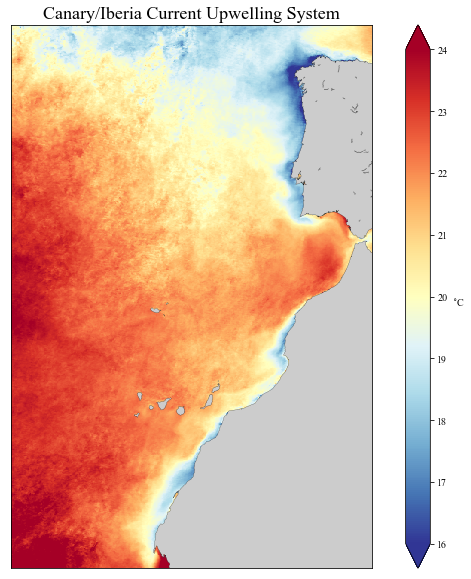

In [54]:
NN = 1
Nw = 10
fig = plt.figure(figsize=(12, 10))
plt.title("Canary/Iberia Current Upwelling System", fontsize=titlefontsize)
llon, llat = np.meshgrid(loncan, latcan)
pcm = mcan.pcolormesh(llon, llat, sstcan, cmap=plt.cm.RdYlBu_r, latlon=True, vmin=16., vmax=24.)
cb = plt.colorbar(pcm, extend="both")
cb.set_label("$^{\circ}$C", rotation=0, ha="left")
mcan.drawcoastlines(linewidth=0.2)
mcan.fillcontinents()
plt.savefig(os.path.join(figdir, "SST_summer2018_Canbus"), dpi=300, bbox_inches="tight")

plt.show()
plt.close()